In [1]:
using CollectiveSpins
using PyPlot
using Statistics
using JLD2
using ProgressMeter
using QuantumOptics
using OrdinaryDiffEq
using Random

In [ ]:
""" Prepare the initial state of the system 
with a phase correlation imposed between the atoms
because the laser arrive on the lattice with an angle θl """
function prepare_phi_IS(θl, λl, theta_array)
    phi_array = zeros(N)
    for i = 1:N
        phi_array[i] = 2pi * sqrt(sum((system.spins[i].position .* [cos(θl), sin(θl), 0]) .^ 2))
    end
    return phi_array
end

""" Prepare the initial vector u0 """
function u0_CFunction(phi_array, theta_array, op_list)
    u0 = ones(ComplexF64, length(op_list))
    for i in 1:length(op_list)
        if length(op_list[i]) == 1
            j = Int(op_list[i][1] % 10^floor(log10(abs(op_list[i][1]))-1)) # Atom nbr
            if parse(Int, string(op_list[i][1])[1:2]) == 22
                u0[i] = cos(theta_array[j]/2)^2
            elseif parse(Int, string(op_list[i][1])[1:2]) == 21
                u0[i] = cos(theta_array[j]/2)*exp(1im*phi_array[j])*sin(theta_array[j]/2)
            else
                println(op_list[i][1])
            end
        end

        if length(op_list[i]) == 2
            for op in op_list[i]
                j = Int(op % 10^floor(log10(abs(op))-1)) # Atom nbr
                if parse(Int, string(op)[1:2]) == 22
                    u0[i] *= cos(theta_array[j]/2)^2
                elseif parse(Int, string(op)[1:2]) == 21
                    u0[i] *= cos(theta_array[j]/2)*exp(1im*phi_array[j])*sin(theta_array[j]/2)
                elseif parse(Int, string(op)[1:2]) == 12
                    u0[i] *= cos(theta_array[j]/2)*exp(-1im*phi_array[j])*sin(theta_array[j]/2)
                else
                    println(op)
                end
            end
        end
    end
    return u0
end

""" Prepare the initial state with NES atoms in the excited state. 
For the maximum slope, the only interesting case is starting from NES atoms up.
Else, no distinction between HelecDD and HelecDD + HmgtDD """
function prepare_init_state(N_ES)
    return shuffle(vcat(zeros(Int, N_ES), pi*ones(Int, N-N_ES))), zeros(N)
end

prepare_init_state

### Define the system

In [3]:
# Define geometry of system
Nx,Ny,Nz = [5,5,1]
N = Nx*Ny*Nz
d_xy, d_z = 266., 532. # Optical lattice spacing in nm
e = [0,0,1]   # Quantization axis

λ = 1299.
θl = 30*pi/180 # Angle of the laser

a,b,c = [d_xy,d_xy,d_z]/λ
geo = geometry.box(a,b,c;Nx=Nx,Ny=Ny,Nz=Nz)
system = SpinCollection(geo, e, gammas=1.)

repetitions = 10 # Nbr of repetitions per NES

Tstep, Tend = 1e-3, 1 # Normalised by Γ0
T = [0:Tstep:Tend;];

# Loop over NES

In [ ]:
var_FF_max_diff_mean_σz = []
std_var_FF_max_diff_mean_σz = []
sols = []

@load "op_list.jdl2" op_list
fsolve(du, u, p, t) = ccall(("diffeqf", "liballfuncs.dll"), Cvoid, (Ptr{ComplexF64}, Ptr{ComplexF64}), du, u)

@showprogress for NES = 1:2:N
    max_diff_σz_rep = []
    for r in 1:repetitions
        theta_array_NES, phi_array_NES = prepare_init_state(NES)
        u0 = u0_CFunction(phi_array_NES, theta_array_NES, op_list)
        prob = OrdinaryDiffEq.ODEProblem(fsolve, u0, (T[1], T[end]))
        sol = OrdinaryDiffEq.solve(prob, OrdinaryDiffEq.DP5(), saveat=T;
                reltol=1.0e-6,
                abstol=1.0e-8).u
        mean_σz_QC = [2*sum(real(sol[t][1:N]))./N-1 for t=1:length(T)]
        mean_σz67_QC = -1 .*(mean_σz_QC.+1) ./2 .- 6
        push!(sols, mean_σz67_QC)
        push!(max_diff_σz_rep, maximum(diff(mean_σz67_QC)./Tstep))
    end
    push!(var_FF_max_diff_mean_σz, mean(max_diff_σz_rep)[1])
    push!(std_var_FF_max_diff_mean_σz, std(max_diff_σz_rep)[1])
end

Progress: 100%|█████████████████████████████████████████| Time: 0:26:31


In [10]:
@save "NES_MaxSlope_QC_Nx_$(Nx)_Ny_$(Ny)_Nz_$(Nz)_theta_$(round(0, digits=1))_phi_$(0)_thetal_$(round(θl, digits=2)).jld2" var_FF_max_diff_mean_σz std_var_FF_max_diff_mean_σz sols

# Plots

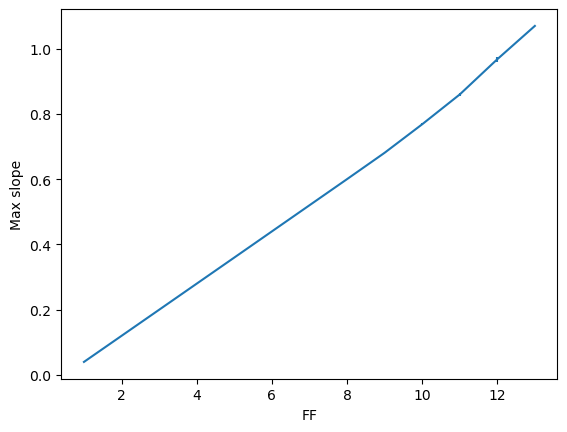

In [14]:
close("all")

errorbar([i for i =1:length(var_FF_max_diff_mean_σz)], var_FF_max_diff_mean_σz, yerr=std_var_FF_max_diff_mean_σz)

xlabel("FF")
ylabel("Max slope")

pygui(false); gcf()
#pygui(true); show()

# Plot solutions

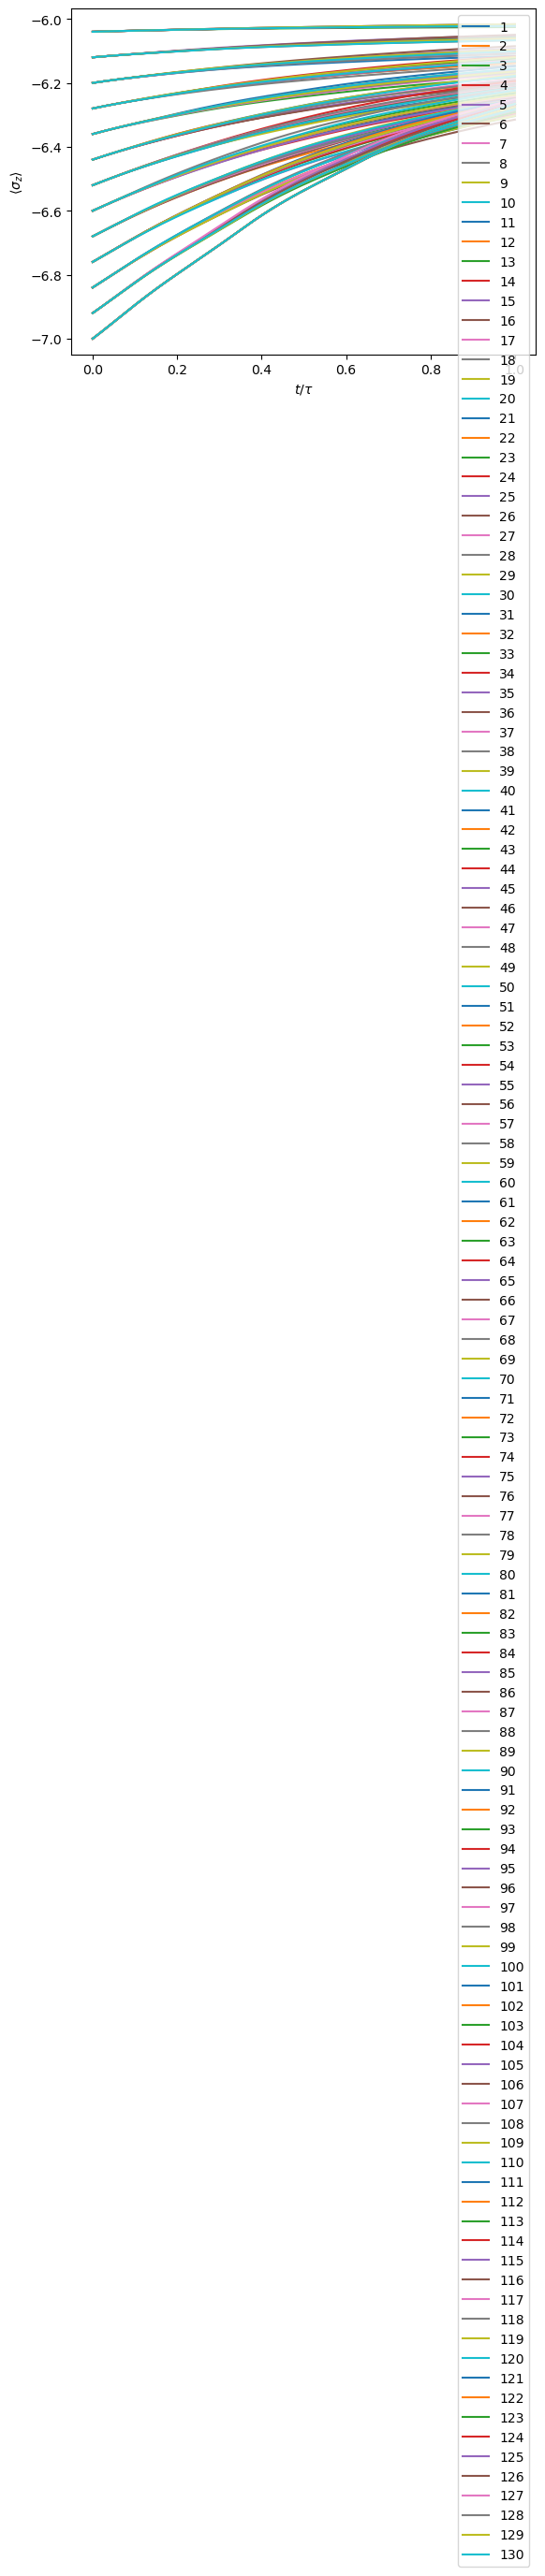

In [12]:
close("all")
figure()

nbr_at = 1
for i = 1:length(sols)
    plot(T, sols[i], label=string(i))
    nbr_at += 1
end

legend()
xlabel(L"t/\tau")
ylabel(L"\langle\sigma_z\rangle")

pygui(false); gcf()

In [28]:
diff(sols[1])

1000-element Vector{Float64}:
 3.992317305545612e-5
 3.9769999597538686e-5
 3.9617558875271186e-5
 3.946586700376287e-5
 3.931494010078751e-5
 3.916479428234254e-5
 3.9015445665313564e-5
 3.886690965870798e-5
 3.871919974862692e-5
 3.857233592530207e-5
 ⋮
 8.184061098148732e-6
 8.17306248990235e-6
 8.161977489429262e-6
 8.150805656192972e-6
 8.139548321572931e-6
 8.128208668800596e-6
 8.116788295708943e-6
 8.10528879480188e-6
 8.09371176480056e-6

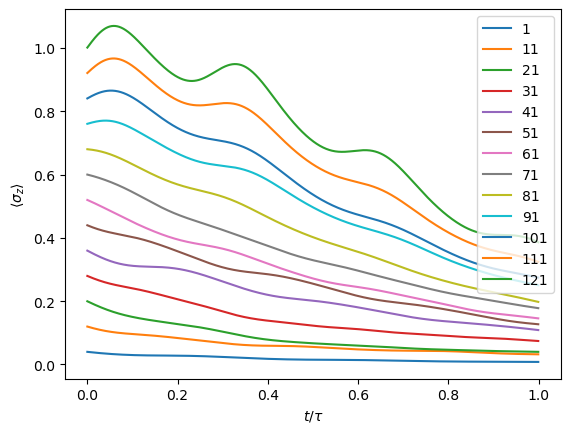

In [29]:
close("all")
figure()

nbr_at = 1
for i = 1:repetitions:length(sols)
    plot(T[1:end-1], diff(sols[i])./Tstep, label=string(i))
end

legend()
xlabel(L"t/\tau")
ylabel(L"\langle\sigma_z\rangle")

pygui(false); gcf()

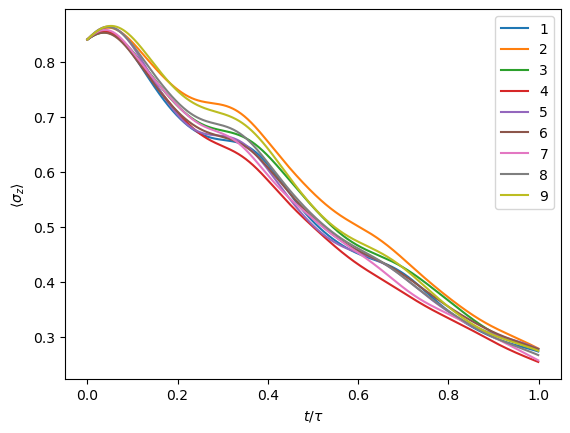

In [33]:
close("all")
figure()

nbr_at = 1
for r = 1:repetitions-1
    plot(T[1:end-1], diff(sols[end-r-20])./Tstep, label=string(r))
end

legend()
xlabel(L"t/\tau")
ylabel(L"\langle\sigma_z\rangle")

pygui(false); gcf()